# Introduction - UCIML Data

This notebook imports, verifies, and preprocesses the spam email data from the UCI Machine Learning dataset, accessible [here](https://www.kaggle.com/uciml/sms-spam-collection-dataset). A baseline model is then made, and compared to the original model made in the plain `data_cleaning_and_modeling.ipynb` notebook.

> *Note: This notebook follows the same general procedures as the one mentioned above, but it is not identical.*

# Libraries

In [1]:
import pandas as pd
import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.utils
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D, GlobalAveragePooling1D
from keras import initializers, regularizers, constraints, optimizers, layers

from sklearn.model_selection import train_test_split

import pickle

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Import Data

First we import the CSV and make sure it looks normal, then drop the three useless columns.

In [2]:
df = pd.read_csv('../data/UCIML_spam.csv', encoding = 'latin1')

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df.drop(columns = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1,
       inplace = True)

## Check Data Types

Checking that every entry is non-null and a string.

In [5]:
print(df.info(), "\n\n")
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
v1    5572 non-null object
v2    5572 non-null object
dtypes: object(2)
memory usage: 87.2+ KB
None 


v1    0
v2    0
dtype: int64


Everything looks good to go.

# Prepare Data For Modeling

## Prepare Email Message Content

Since the data is strings made of space-separated words, we need to first tokenize it. This gives us lists of integers corresponding to words-in-order. These lists are turned into arrays and padded, so that they are uniform in length.

In [6]:
# Example in
df['v2'][2]

"Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

In [7]:
# Instantiate and fit a Tokenizer on the messages
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['v2'])
X = tokenizer.texts_to_sequences(df['v2'])
X = np.array(X)
X = pad_sequences(X, maxlen=100)
with open('../models/tokenizer_UCIML.pickle', 'wb') as f:
    pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
# Example out
print(X[5])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0  797  127   67
 1683  145  108  160 1934   21    7   38  338   87  900   55  115  411
    3   44   12   14   85 1935   46  380  955 4412    2   68  322  230
    2 2990]


## Prepare Email Labels

Printed below is an example (read: reminder) that we just have two categories here. They will be converted to integers and then to categoricals, i.e. `"Non-Spam"` --> `0` --> `[1, 0]` and vice versa.

In [9]:
# Label example
df['v1'].head(6)

0     ham
1     ham
2    spam
3     ham
4     ham
5    spam
Name: v1, dtype: object

In [10]:
# Define int replacements
label_dict = {"ham": 0, "spam": 1}

# Replace labels with int and pass to to_categorical()
y = keras.utils.to_categorical([label_dict[label] for label in df['v1']])

In [11]:
# Finished example, matches above
print(y[0:6])

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


## Test Train Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

We now have our `X_train`, `X_test`, `y_train`, and `y_test` ready and can begin modeling.

# Baseline Model

This model has about 4x the vocabulary size as the *original* baseline (in `data_cleaning_and_modeling.ipynb` in the directory above this one). Expecting lower performance.

In [13]:
all_words = df['v2'].str.split() 
total_vocab = set(word for text in all_words for word in text)
len(total_vocab)

15585

In [14]:
# Instantiate model
base_model = Sequential()

# Add model layers based on above rationale
base_model.add(Embedding(len(total_vocab), 100))
base_model.add(LSTM(8, return_sequences=True))
base_model.add(GlobalMaxPool1D())
base_model.add(Dense(25, activation='tanh'))
base_model.add(Dense(2, activation='softmax'))

# Compile model
base_model.compile(loss='categorical_crossentropy',
                   optimizer='Adam',
                   metrics=['accuracy'])

# Fit model and store results
base_results = base_model.fit(X_train, y_train,
                              epochs=20, batch_size=30,
                              validation_split=0.2)

Train on 3565 samples, validate on 892 samples
Epoch 1/20
3565/3565 [==============================] - 13s 4ms/step - loss: 0.3442 - acc: 0.8870 - val_loss: 0.1241 - val_acc: 0.9821
Epoch 2/20
3565/3565 [==============================] - 13s 4ms/step - loss: 0.0618 - acc: 0.9871 - val_loss: 0.0547 - val_acc: 0.9865
Epoch 3/20
3565/3565 [==============================] - 13s 4ms/step - loss: 0.0220 - acc: 0.9952 - val_loss: 0.0548 - val_acc: 0.9877
Epoch 4/20
3565/3565 [==============================] - 13s 4ms/step - loss: 0.0076 - acc: 0.9986 - val_loss: 0.0612 - val_acc: 0.9865
Epoch 5/20
3565/3565 [==============================] - 13s 4ms/step - loss: 0.0040 - acc: 0.9994 - val_loss: 0.0640 - val_acc: 0.9865
Epoch 6/20
3565/3565 [==============================] - 13s 4ms/step - loss: 0.0029 - acc: 0.9997 - val_loss: 0.0681 - val_acc: 0.9877
Epoch 7/20
3565/3565 [==============================] - 13s 4ms/step - loss: 0.0022 - acc: 0.9997 - val_loss: 0.0695 - val_acc: 0.9843
Epoch 8/

In [15]:
# Helper function to visualize model performance over training
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

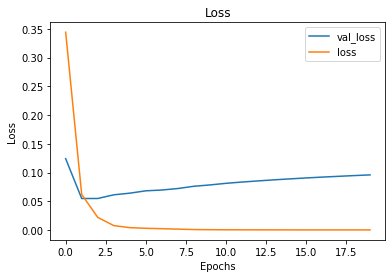

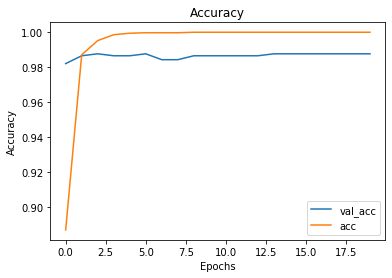

In [16]:
# Visualize baseline model performance
visualize_training_results(base_results)

Again, I'm pleasantly surprised. This model converged extremely quickly, and to a fairly high level of accuracy, 100% for the training and 98.77% for the validation set. For now, I'm offloading this model for persistence sake, but will be training a few more models to see if we can:
- Reduce complexity
- Increase `val_acc`

In [17]:
# Save the trained model
base_model.save('../models/UCIML_base_model')